In [1]:
import json
import argparse
from collections import defaultdict
import glob
from os import path
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import csv



In [2]:
# parser = argparse.ArgumentParser(
#     description='Adds metadata to a json file')
# parser.add_argument('file')
# args = parser.parse_args()

# file = args.file
files = glob.glob('data/*.json')
confs = defaultdict(dict)
for file in files:
    data = json.load(open(file, 'r'))
    conf_name = path.basename(file).split('.')[0]
    conf_name, year = conf_name.split('_')
    data = json.load(open(file, 'r'))
    for paper in data:
        try:
            paper['text'] = open(f"data/pdfs/{paper['id']}.txt", 'r').read().lower()
        except:
            paper['text'] = "N/A"
            pass
    confs[conf_name][year] = data




In [3]:
begin = time.time()
synonyms = {
    'facebook': ["facebook ai research", 'fb.com'],
    'google': ['google.com', 'google brain'],
    'pytorch': ['pytorch', 'allennlp', 'opennmt-py', 'torchvision', 'huggingface', 'fairseq'],
    'opennmt': ['opennmt-py', 'opennmt-tf'],
    'tensorflow': ['tensorflow', 'opennmt-tf'],
    'keras': ['keras'],
    'stanford': ['@cs.stanford.edu', '@stanford.edu'],
    'mit': ['@csail.mit.edu', '@mit.edu'],
    'uw': ['@cs.washington.edu', '@washington.edu'],
    'cornell': ['@cs.cornell.edu', '@cornell.edu'],
    'cmu': ['@cmu.edu', '@cs.cmu.edu'],
    'theano': ['theano'],
    'deepmind': ['deepmind'],
    'mxnet': ['mxnet'],
    'dynet': ['dynet'],
    'autobatching': ['auto-batching', 'autobatching'],
    'parsing': ['parsing'],
    'paddle': ['paddlepaddle']
#     'architecture search': ['architecture search'],
#     'gan': ['generative adversarial network'],
#     'rl': ['reinforcement learning'],
#     'bayesian': ['bayesian'],
#     'meta-learning': ['meta-learning', 'metalearning'],
#     'few-shot': ['few shot', 'few-shot', 'one shot', 'one-shot'],
#     'graph': ['graph neural network'],
#     'generative': ['generative model'],
#     'adversarial': ['adversarial attack', 'ifgsm'],
}
for k, v in synonyms.items():
    synonyms[k] = [i.lower() for i in v]
    
words = set([i for k,v in synonyms.items() for i in v])
mapping = defaultdict(list)
for k, vs in synonyms.items():
    for v in vs:
        mapping[v].append(k)
        mapping[v].append(v)

word_sets = defaultdict(lambda: defaultdict(lambda: defaultdict(set)))
for conf in confs:
    for year in confs[conf]:
        data = confs[conf][year]
        word_set = word_sets[conf][year]
        for paper in data:
            for word in words:
                if word in paper['text']:
                    if word in mapping:
                        for key in mapping[word]:
                            word_set[key].add(paper['id'])

print(time.time() - begin)  

8.862112045288086


In [4]:
conf_month = {
    'eccv': 'september',
    'acl': 'july',
    'naacl': 'june',
    'acl': 'august',
    'icml': 'june',
    'cvpr': 'june',
    'nips': 'december',
    'aistats': 'april',
    'colt': 'june',
    'iclr': 'may',
    'iccv': 'november',
    'emnlp': 'november'
}
conf_month = {
    k: time.strptime(v, '%B').tm_mon for k, v in conf_month.items()}
import matplotlib.style as style
style.use('default')

eccv
2018
total papers 776
pytorch 97
tensorflow 95

acl
2017
total papers 302
pytorch 0
tensorflow 23
2018
total papers 381
pytorch 26
tensorflow 34
2019
total papers 720
pytorch 103
tensorflow 33

naacl
2018
total papers 330
pytorch 12
tensorflow 34
2019
total papers 451
pytorch 66
tensorflow 21

icml
2017
total papers 434
pytorch 3
tensorflow 31
2018
total papers 621
pytorch 23
tensorflow 40
2019
total papers 773
pytorch 69
tensorflow 53

cvpr
2015
total papers 602
pytorch 0
tensorflow 0
2016
total papers 643
pytorch 0
tensorflow 1
2017
total papers 783
pytorch 0
tensorflow 44
2018
total papers 979
pytorch 82
tensorflow 116
2019
total papers 1294
pytorch 280
tensorflow 125

nips
2015
total papers 403
pytorch 0
tensorflow 0
2016
total papers 569
pytorch 0
tensorflow 7
2017
total papers 679
pytorch 9
tensorflow 66
2018
total papers 1009
pytorch 68
tensorflow 88

iclr
2018
total papers 337
pytorch 24
tensorflow 53
2019
total papers 502
pytorch 70
tensorflow 52

iccv
2017
total papers 6

Text(0.5, 1.0, 'Original vs. Keras Corrected')

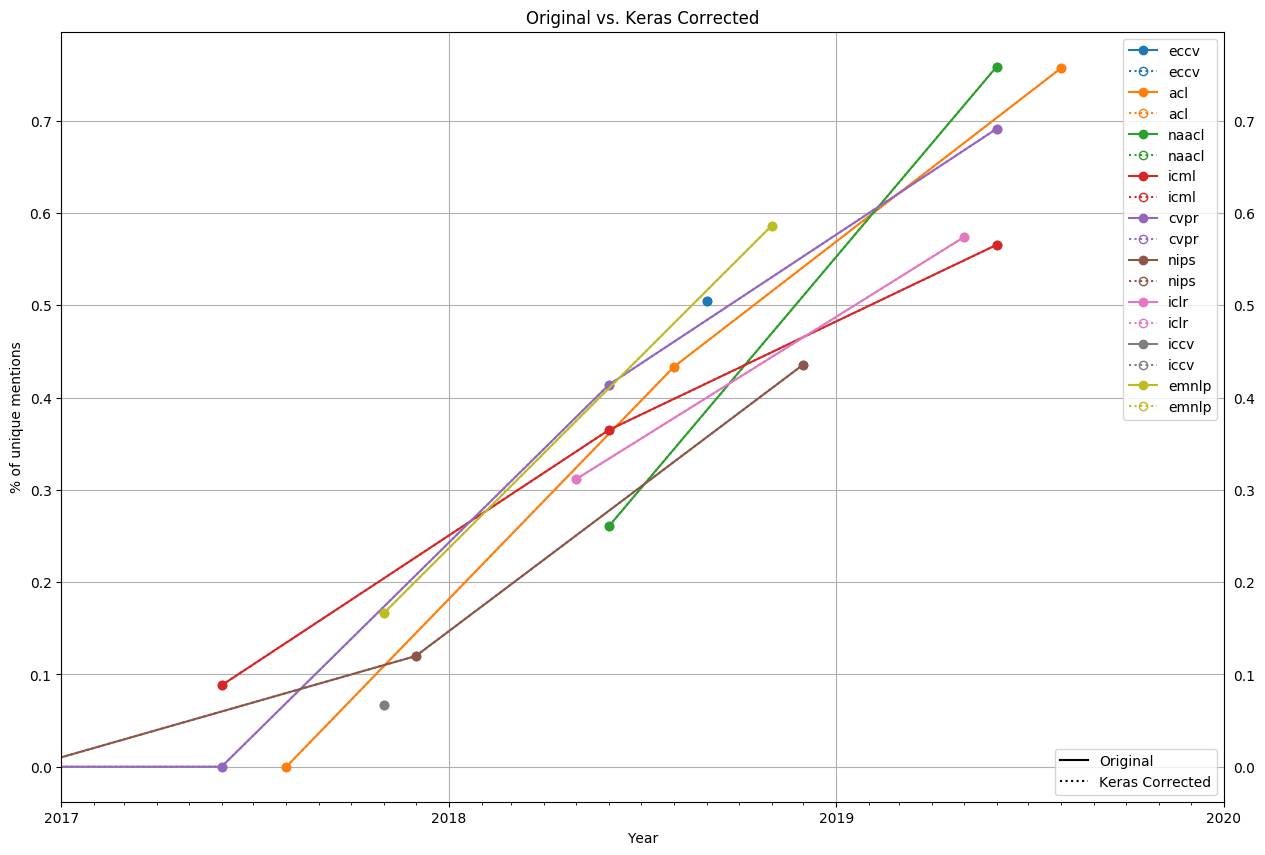

In [7]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()

# ax.set_ylim(0,125)

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_xlim(np.datetime64('2017'), np.datetime64('2020'))
ax.set_facecolor((1,1,1,1))
plt.rcParams["figure.figsize"] = (15,10)
plt.tick_params(labelright=True)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
nlp_confs = ['naacl', 'acl', 'emnlp']
cv_confs = ['cvpr', 'eccv', 'iccv']
ml_confs = ['nips', 'iclr', 'icml']
csvfile = open('data.csv', 'w')
writer = csv.writer(csvfile)
for conf in confs:
    if conf == 'colt' or conf == 'aistats':
        continue
    pytorch = []
    pytorch_corr = []
    tf = []
    tf_corr = []
    dates = []
    print(conf)
    for year in sorted(confs[conf]):
        ws = word_sets[conf][year]
        date = np.datetime64(f"{year}-{conf_month[conf]:02}")
        dates.append(date)

        pytorch_set = ws['pytorch'] - ws['tensorflow']
        tf_set = ws['tensorflow'] - ws['pytorch']
        biased_set = ws['facebook'] | ws['google']
        pytorch.append(len(pytorch_set - biased_set))
        tf.append(len(tf_set - biased_set))
        pytorch_corr.append(len(pytorch_set - biased_set))
        tf_corr.append(len(tf_set- biased_set ))
        writer.writerow([conf, f"{conf_month[conf]:02}/{year[2:]}", pytorch_corr[-1], tf_corr[-1]])
#         if len(tf_set) > 0:
#             print(len(pytorch_set - biased_set)/(len(pytorch_set - biased_set) + len(tf_set - biased_set)))
        print(year)
#         print(pytorch_set)

        print("total papers", len(confs[conf][year]))
#         print("ratio: ", len(ws['pytorch'] | ws['tensorflow'])/len(confs[conf][year]))
        print("pytorch", len(pytorch_set - biased_set))
#         print("pytorch independent", pytorch_corr[-1])
        print("tensorflow", len(tf_set - biased_set))
#         print(tf_set)
#         print("tensorflow independent", tf_corr[-1])
    print()
#     plt.figure()
    c=prop_cycle[0]
    prop_cycle = prop_cycle[1:] + prop_cycle[:1]
#     alpha = 1.0 if conf in ['naacl', 'acl', 'emnlp'] else 0.1
#     alpha = 1.0 if conf in nlp_confs else 0.2
    alpha = 1.0
    plt.plot(dates, 
            [a/(a+b) if a+b > 0 else None for a,b in zip(pytorch_corr, tf_corr)],
#              pytorch_corr,
            label = conf,
            marker = 'o',
             color = c,
            alpha=alpha)
    plt.plot(dates, 
             [a/(a+b) if a+b > 0 else None for a,b in zip(pytorch, tf)],
#              tf_corr,
            label = conf,
            marker = 'o',
            markerfacecolor='none',
            linestyle=':',
            color=c,
            alpha=alpha)
    
    plt.legend()
plt.ylabel('% of unique mentions')
vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.xlabel('Year')
#     plt.plot(dates, pytorch, color='blue')
#     plt.plot(dates, tf, color='orange')
solid_line = Line2D([0], [0], color='black', label='Original')
dashed_line = Line2D([0], [0], linestyle=':', color='black', label='Keras Corrected')
csvfile.close()

legend1 = plt.legend(handles=[solid_line, dashed_line], loc=4)
plt.legend()
plt.grid()
plt.gca().add_artist(legend1)

plt.title("Original vs. Keras Corrected")


In [7]:
conf = 'cvpr'
for year in sorted(confs[conf]):
    ws = word_sets[conf][year]

    print(year)
    print("total papers", len(confs[conf][year]))
    print("pytorch", len(ws['pytorch'] - ws['facebook']))
    print("pytorch independent", len(ws['pytorch'] - ws['facebook'] - ws['tensorflow']))
    print("tensorflow", len(ws['tensorflow']))
    print("tensorflow independent", len(ws['tensorflow'] - ws['google'] - ws['pytorch']))
#     print("allennlp", len(ws['allennlp']))
#     print("dynet", len(ws['dynet']))
#     print(ws['dynet'] & ws['parsing'])
#     print(ws['dynet'] & ws['autobatching'])
#     print(ws['dynet'] - ws['autobatching'] - ws['parsing'])
#     print('huggingface', len(ws['huggingface']))
#     print('opennmt-py', len(ws['opennmt-py']))
#     print('fairseq', len(ws['fairseq']))
#     print('opennmt', len(ws['opennmt-py']))
    print()


2015
total papers 602
pytorch 0
pytorch independent 0
tensorflow 0
tensorflow independent 0

2016
total papers 643
pytorch 0
pytorch independent 0
tensorflow 2
tensorflow independent 1

2017
total papers 783
pytorch 0
pytorch independent 0
tensorflow 59
tensorflow independent 44

2018
total papers 979
pytorch 88
pytorch independent 83
tensorflow 136
tensorflow independent 117

2019
total papers 1294
pytorch 309
pytorch independent 284
tensorflow 165
tensorflow independent 126



In [92]:
pytorch = set()
tf = set()
fb = set()
google = set()
for i in word_sets.values():
    for j in i.values():
        pytorch |= j['pytorch']
        tf |= j['tensorflow']
        fb |= j['facebook']
        google |= j['google']
print(len(pytorch & fb)/len(fb))
print(len(google & tf)/len(google))

0.1791907514450867
0.23529411764705882


In [8]:
authors = defaultdict(lambda :defaultdict(list))
for conf in confs:
    if conf in ['aistats', 'colt']:
        continue
    for year in ['2018', '2019']:
        ws = word_sets[conf][year]
        if year not in confs[conf]:
            continue
        for paper in confs[conf][year]:
            cur_authors = paper['authors']
            for i in cur_authors:
                i = i.strip()
            if paper['id'] in ws['google'] | ws['facebook']:
                continue 
            for i in cur_authors[-1:]:

                if paper['id'] in ws['pytorch'] - ws['tensorflow']:
                    authors[i][year].append('pytorch')
                elif paper['id'] in ws['tensorflow'] - ws['pytorch']:
                    authors[i][year].append('tf')
                else:
                    authors[i][year].append('')
#             print(paper['id'] in ws['pytorch'])
#             break
#         print(len(confs[conf][year]))

In [9]:
pt_converts = []
tf_converts = []
pt_new = []
tf_new = []
tf_stay = []
pt_stay = []
total_pt = []

for name in authors:
    def sgn(x):
        if x == 0: return 0
        return 1 if x>0 else -1

    def convert_score(s):
        if s == 'pytorch': return 1
        elif s == 'tf': return -1
        else: return 0
    author = authors[name]
    if len(author['2019']) == 0:
        continue
    cnts18 = sum([convert_score(i) for i in author['2018']])
    cnts19 = sum([convert_score(i) for i in author['2019']])
    published18 = len(author['2018']) > 0
    published19 = len(author['2019']) > 0
    if sgn(cnts19) == 1:
        total_pt.append((name, author))
    if published18 and published19:
        if sgn(cnts18) == 1 and sgn(cnts19) == -1:
#             print('tf convert', name, author)
            tf_converts.append((name, author))
        elif sgn(cnts18) == -1 and sgn(cnts19) == 1:
#             print('pt convert', name, author)
#             print(name, author['google'])
            
            pt_converts.append((name, author))
        elif sgn(cnts18) == sgn(cnts19) and cnts19 == -1:
            tf_stay.append((name, author))
        elif sgn(cnts18) == sgn(cnts19) and cnts19 == 1:
            pt_stay.append((name, author))
    elif not published18 and published19:
        if sgn(cnts19) == 1:
#             print('new pt', name, author)
            pt_new.append((name, author))
        elif sgn(cnts19) == -1:
            tf_new.append((name, author))
#             print('new tf', name, author)
    

        

In [10]:
print(len(pt_converts))
print(len(tf_converts))
print()
print(len(pt_new))
print(len(tf_new))
print()
print(len(pt_stay))
print(len(tf_stay))
print()
print(len(total_pt))

23
3

332
170

32
20

471


In [254]:
print(tf_converts)

[('Tiejun Zhao', defaultdict(<class 'list'>, {'2018': ['', 'pytorch', ''], '2019': ['', '', 'tf', '', '']})), ('Jinwen Ma', defaultdict(<class 'list'>, {'2018': ['pytorch'], '2019': ['', 'tf']})), ('Ligeng Zhu', defaultdict(<class 'list'>, {'2018': ['pytorch'], '2019': ['tf']})), ('Min-Yen Kan', defaultdict(<class 'list'>, {'2018': ['pytorch'], '2019': ['', 'tf']})), ('Julian McAuley', defaultdict(<class 'list'>, {'2018': ['pytorch', '', ''], '2019': ['', '', 'tf']})), ('Ryan Cotterell', defaultdict(<class 'list'>, {'2019': ['', '', '', '', '', '', '', '', '', '', '', '', 'tf'], '2018': ['', '', '', 'pytorch']})), ('Kun Bai', defaultdict(<class 'list'>, {'2019': ['tf'], '2018': ['pytorch']})), ('Tianyi Zhou', defaultdict(<class 'list'>, {'2019': ['tf', '', ''], '2018': ['pytorch', 'pytorch', 'tf']})), ('Erick Cobos', defaultdict(<class 'list'>, {'2018': ['pytorch'], '2019': ['tf']})), ('Emmanouil Froudarakis', defaultdict(<class 'list'>, {'2018': ['pytorch'], '2019': ['tf']})), ('Jacob

In [264]:
print(pt_converts)

[('Trevor Darrell', defaultdict(<class 'list'>, {'2018': ['', '', '', '', '', '', '', '', '', '', '', 'tf', ''], '2019': ['', '', 'pytorch']})), ('Dongze Lian', defaultdict(<class 'list'>, {'2018': ['', 'tf'], '2019': ['pytorch']})), ('Nenghai Yu', defaultdict(<class 'list'>, {'2018': ['', '', 'tf', ''], '2019': ['pytorch']})), ('Chen Sun', defaultdict(<class 'list'>, {'2018': ['', 'tf', 'tf', 'tf'], '2019': ['', '', 'pytorch']})), ('Angjoo Kanazawa', defaultdict(<class 'list'>, {'2018': ['', '', '', 'tf'], '2019': ['', 'pytorch']})), ('Muhammed Kocabas', defaultdict(<class 'list'>, {'2018': ['tf'], '2019': ['pytorch']})), ('Huan Zhang', defaultdict(<class 'list'>, {'2018': ['pytorch', 'tf', 'tf', '', ''], '2019': ['', '', '', 'pytorch']})), ('Cho-Jui Hsieh', defaultdict(<class 'list'>, {'2018': ['pytorch', 'tf', '', '', '', '', '', 'tf'], '2019': ['', '', 'pytorch', 'pytorch']})), ('Jie Zhou', defaultdict(<class 'list'>, {'2018': ['', 'tf', '', '', '', 'pytorch', 'tf', 'tf', '', '', '

In [11]:
print(tf_stay)

[('Hongdong Li', defaultdict(<class 'list'>, {'2018': ['tf', ''], '2019': ['tf']})), ('Xueqi Cheng', defaultdict(<class 'list'>, {'2018': ['tf', 'tf', '', ''], '2019': ['tf', '']})), ('Rui Yan', defaultdict(<class 'list'>, {'2019': ['', 'tf', 'pytorch', 'tf'], '2018': ['', '', 'tf']})), ('Zenglin Xu', defaultdict(<class 'list'>, {'2019': ['tf'], '2018': ['tf']})), ('Siu Cheung Hui', defaultdict(<class 'list'>, {'2019': ['tf'], '2018': ['tf', 'tf', 'tf', 'tf']})), ('David Bamman', defaultdict(<class 'list'>, {'2019': ['', 'tf'], '2018': ['tf']})), ('Chengqi Zhang', defaultdict(<class 'list'>, {'2019': ['tf'], '2018': ['tf']})), ('Philipp Hennig', defaultdict(<class 'list'>, {'2018': ['tf'], '2019': ['tf']})), ('Lawrence Carin Duke', defaultdict(<class 'list'>, {'2018': ['', '', 'tf'], '2019': ['tf', '']})), ('Frank Hutter', defaultdict(<class 'list'>, {'2018': ['tf'], '2019': ['', '', 'tf']})), ('Francois Fleuret', defaultdict(<class 'list'>, {'2018': ['tf', ''], '2019': ['tf']})), ('Pe